# Breakhis-400x Dataset

In [3]:
print("Welcome")

Welcome


# Evaluation Function

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    mean_absolute_error, 
    mean_squared_error,
    confusion_matrix
)

# Function to evaluate the model and print metrics
def evaluate_model(model_name, model, test_generator):
    # Reset the generator to start from the beginning
    test_generator.reset()  
    
    # Get predictions
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Binarize predictions
    y_true = test_generator.classes  # True labels

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_prob)

    # Calculate specificity
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Specificity: {specificity:.4f}\n")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'Confusion_{model_name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()

# Final DNBCD Model (Custom CNN + DenseNet + Transfer Learning)

In [35]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 582ms/step - accuracy: 0.5882 - loss: 0.8587 - val_accuracy: 0.7912 - val_loss: 0.5501
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6795 - loss: 0.6265 - val_accuracy: 0.5549 - val_loss: 0.6520
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.6635 - loss: 0.6182 - val_accuracy: 0.8132 - val_loss: 0.4928
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7337 - loss: 0.5502 - val_accuracy: 0.8187 - val_loss: 0.4426
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7721 - loss: 0.5192 - val_accuracy: 0.8462 - val_loss: 0.4051
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7850 - loss: 0.4849 - val_accuracy: 0.8187 - val_loss: 0.4503
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7862 - loss: 0.4619 - val_accuracy: 0.8297 - val_loss: 0.4081
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.8010 - loss: 0.4555 - val_accuracy: 0.8462 - val

In [6]:
model.save("DNBCD_Model.h5")

In [7]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 22,716,997 (86.66 MB)

 Trainable params: 7,544,449 (28.78 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 15,088,900 (57.56 MB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 635ms/step
Accuracy: 0.9397
Precision: 0.9747
Recall: 0.9352
F1 Score: 0.9545
Mean Absolute Error: 0.0603
Root Mean Square Error: 0.2455
AUC Score: 0.9924
Specificity: 0.9492


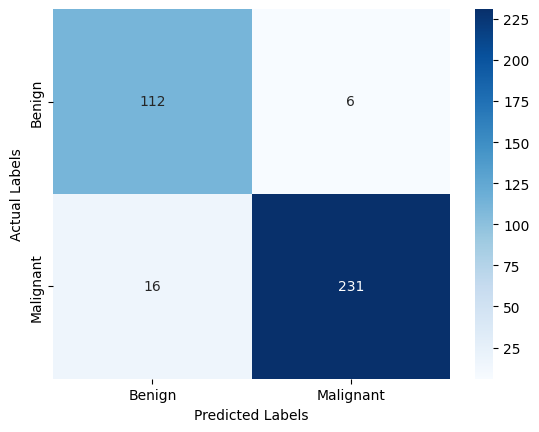

In [36]:
model_name= "DNBCD"
evaluate_model(model_name,model, test_generator)

# Mobilenet+transfer

In [9]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained MobileNet model + higher-level layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
mobilenet_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
mobilenet_history_initial = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
mobilenet_history_fine = mobilenet_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = mobilenet_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 312ms/step - accuracy: 0.5761 - loss: 0.8775 - val_accuracy: 0.6978 - val_loss: 0.6073
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6536 - loss: 0.6342 - val_accuracy: 0.7967 - val_loss: 0.4786
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7482 - loss: 0.5500 - val_accuracy: 0.7308 - val_loss: 0.5040
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.7177 - loss: 0.5414 - val_accuracy: 0.7747 - val_loss: 0.4940
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7247 - loss: 0.5265 - val_accuracy: 0.8187 - val_loss: 0.4113
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7895 - loss: 0.4554 - val_accuracy: 0.8297 - val_loss: 0.4010
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.7566 - loss: 0.4795 - val_accuracy: 0.8187 - val_loss: 0.3648
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8043 - loss: 0.4304 - val_accuracy: 0.8462 - val

In [10]:
mobilenet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 11,414,597 (43.54 MB)

 Trainable params: 3,797,569 (14.49 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 7,595,140 (28.97 MB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step
Model: T_Mobilenet
Accuracy: 0.9233
Precision: 0.9782
Recall: 0.9069
F1 Score: 0.9412
Mean Absolute Error: 0.0767
Root Mean Square Error: 0.2770
AUC Score: 0.9823
Specificity: 0.9576



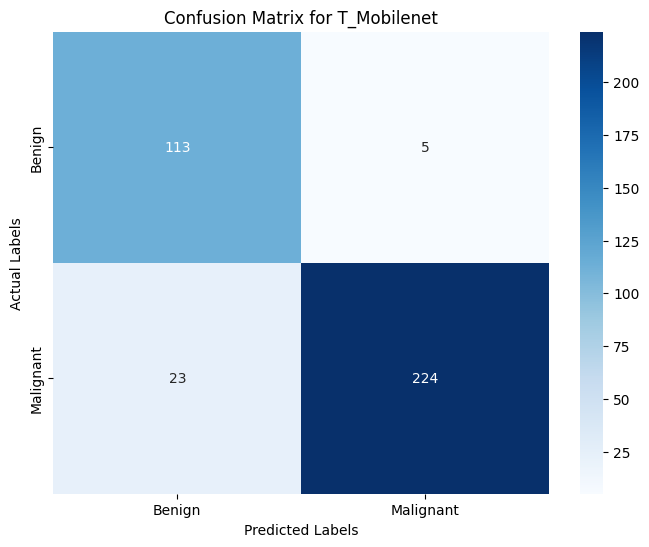

In [11]:
model_name= "T_Mobilenet"
evaluate_model(model_name,mobilenet_model, test_generator)

# Resnet50+transfer

In [12]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight

# Optional: For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained ResNet50 model + higher-level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
resnet50_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
resnet50_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
resnet50_history_initial = resnet50_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
resnet50_history_fine = resnet50_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = resnet50_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 418ms/step - accuracy: 0.4884 - loss: 0.8163 - val_accuracy: 0.3626 - val_loss: 0.7000
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.4526 - loss: 0.7211 - val_accuracy: 0.6758 - val_loss: 0.6818
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.5077 - loss: 0.7001 - val_accuracy: 0.6758 - val_loss: 0.6751
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.4753 - loss: 0.7141 - val_accuracy: 0.6758 - val_loss: 0.6775
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5590 - loss: 0.6924 - val_accuracy: 0.6758 - val_loss: 0.6831
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.5059 - loss: 0.6997 - val_accuracy: 0.6758 - val_loss: 0.6850
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.5632 - loss: 0.6840 - val_accuracy: 0.4451 - val_loss: 0.6931
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.5249 - loss: 0.6889 - val_accuracy: 0.3297 - val

I0000 00:00:1732457274.462829     138 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 16 bytes spill stores, 16 bytes spill loads



40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 830ms/step - accuracy: 0.7010 - loss: 2.1895 - val_accuracy: 0.6758 - val_loss: 1.6902
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.8063 - loss: 0.4291 - val_accuracy: 0.6758 - val_loss: 2.0542
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.8655 - loss: 0.2989 - val_accuracy: 0.6758 - val_loss: 4.7234
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.8987 - loss: 0.2380 - val_accuracy: 0.6758 - val_loss: 7.2160
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accuracy: 0.9271 - loss: 0.1862 - val_accuracy: 0.6758 - val_loss: 13.7195
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9435 - loss: 0.1891 - val_accuracy: 0.6758 - val_loss: 20.3882
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.9518 - loss: 0.1393 - val_accuracy: 0.6758 - val_loss: 10.8062
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - accuracy: 0.9553 - loss: 0.1179 - val_accuracy: 0.6758 - 

In [13]:
resnet50_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 74,001,541 (282.29 MB)

 Trainable params: 24,649,473 (94.03 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 49,298,948 (188.06 MB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 327ms/step
Model: T_Resnet
Accuracy: 0.6740
Precision: 0.6758
Recall: 0.9960
F1 Score: 0.8052
Mean Absolute Error: 0.3260
Root Mean Square Error: 0.5710
AUC Score: 0.6280
Specificity: 0.0000



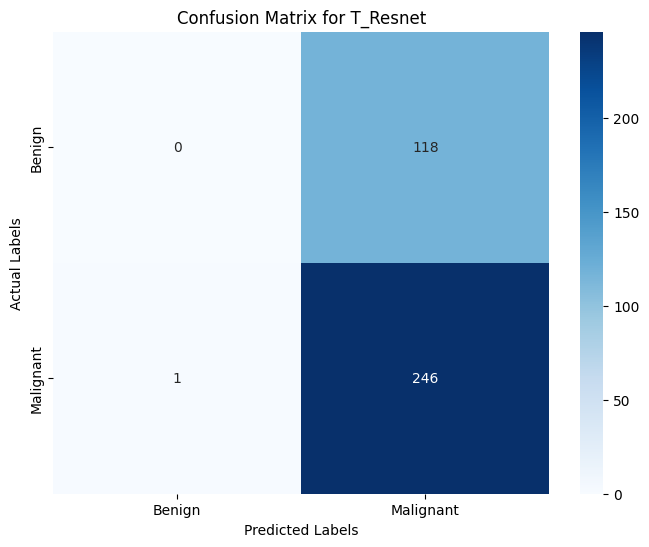

In [14]:
model_name= "T_Resnet"
evaluate_model(model_name,resnet50_model, test_generator)

# Vgg19+transfer

In [15]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.utils.class_weight import compute_class_weight

# Optional: For reproducibility
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG19-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights_array))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained VGG19 model + higher-level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
vgg19_model = Model(inputs=base_model.input, outputs=output)

# Compile the model
vgg19_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
vgg19_history_initial = vgg19_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
vgg19_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
vgg19_history_fine = vgg19_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = vgg19_model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.6274 - loss: 2.2554 - val_accuracy: 0.7747 - val_loss: 0.4400
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6718 - loss: 1.0267 - val_accuracy: 0.7967 - val_loss: 0.4257
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.7366 - loss: 0.6772 - val_accuracy: 0.8187 - val_loss: 0.4377
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7331 - loss: 0.5968 - val_accuracy: 0.8462 - val_loss: 0.4593
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.7292 - loss: 0.5976 - val_accuracy: 0.8681 - val_loss: 0.4286
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.7429 - loss: 0.5755 - val_accuracy: 0.8571 - val_loss: 0.3998
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.7842 - loss: 0.4884 - val_accuracy: 0.7857 - val_loss: 0.4881
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7828 - loss: 0.5221 - val_accuracy: 0.8352 - val

In [16]:
vgg19_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 61,058,501 (232.92 MB)

 Trainable params: 20,352,833 (77.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,705,668 (155.28 MB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step
Model: T_VGG19
Accuracy: 0.8904
Precision: 0.9683
Recall: 0.8664
F1 Score: 0.9145
Mean Absolute Error: 0.1096
Root Mean Square Error: 0.3310
AUC Score: 0.9676
Specificity: 0.9407



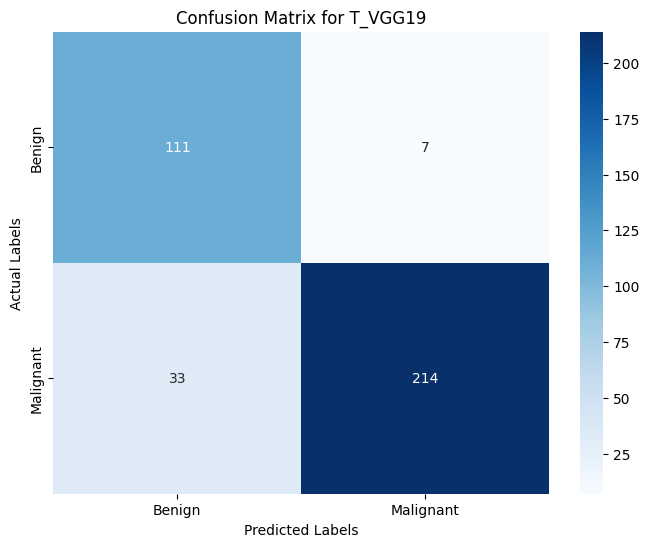

In [17]:
model_name= "T_VGG19"
evaluate_model(model_name,vgg19_model, test_generator) 

# DenseNet121

In [18]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weightFunction

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the complete model
model_densenet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_densenet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_densenet = model_densenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_densenet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 40s 570ms/step - accuracy: 0.5043 - loss: 0.8323 - val_accuracy: 0.4176 - val_loss: 0.8082
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.4622 - loss: 0.7817 - val_accuracy: 0.4670 - val_loss: 0.7785
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5035 - loss: 0.7498 - val_accuracy: 0.4505 - val_loss: 0.7651
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 0.5202 - loss: 0.7610 - val_accuracy: 0.4505 - val_loss: 0.7525
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5395 - loss: 0.7271 - val_accuracy: 0.4890 - val_loss: 0.7333
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5524 - loss: 0.7080 - val_accuracy: 0.4835 - val_loss: 0.7242
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.5944 - loss: 0.6851 - val_accuracy: 0.4725 - val_loss: 0.7173
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 0.5482 - loss: 0.7031 - val_accuracy: 0.5165 - val

In [19]:
model_densenet.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 134, 134,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,040,581 (26.86 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 2,052 (8.02 KB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 696ms/step
Model: Densenet
Accuracy: 0.6822
Precision: 0.8394
Recall: 0.6559
F1 Score: 0.7364
Mean Absolute Error: 0.3178
Root Mean Square Error: 0.5637
AUC Score: 0.7799
Specificity: 0.7373



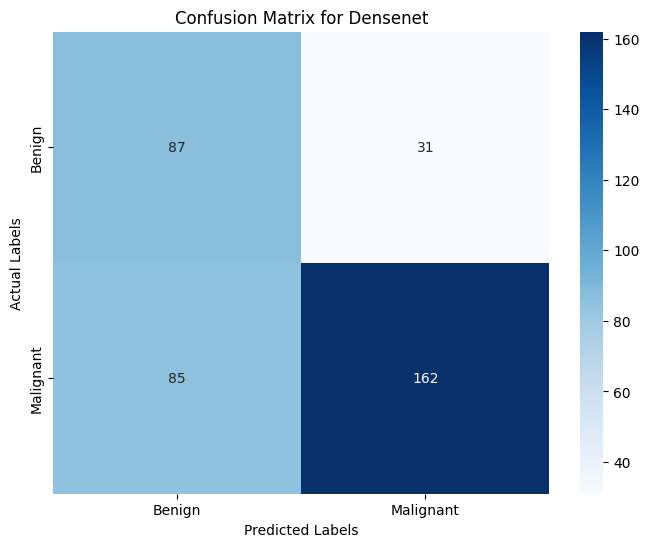

In [20]:
model_name= "Densenet"
evaluate_model(model_name,model_densenet, test_generator)

# Mobilenet

In [21]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained MobileNet model + higher-level layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the complete model
model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_mobilenet = model_mobilenet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_mobilenet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.4823 - loss: 0.7629 - val_accuracy: 0.4286 - val_loss: 0.8539
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.5501 - loss: 0.7512 - val_accuracy: 0.4451 - val_loss: 0.8295
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.5540 - loss: 0.7252 - val_accuracy: 0.4670 - val_loss: 0.8135
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.5995 - loss: 0.6781 - val_accuracy: 0.4890 - val_loss: 0.7853
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.6289 - loss: 0.6229 - val_accuracy: 0.5055 - val_loss: 0.7604
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6373 - loss: 0.6306 - val_accuracy: 0.5275 - val_loss: 0.7480
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.6690 - loss: 0.6126 - val_accuracy: 0.5495 - val_loss: 0.7257
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6519 - loss: 0.6218 - val_accuracy: 0.5549 - val

In [22]:
model_mobilenet.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 64, 64, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 64, 64, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 64, 64, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 64, 64, 64)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 32, 32, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 32, 32, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 32, 32, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 32, 32, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,231,941 (12.33 MB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 2,052 (8.02 KB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
Model: Mobilenet
Accuracy: 0.6932
Precision: 0.8729
Recall: 0.6397
F1 Score: 0.7383
Mean Absolute Error: 0.3068
Root Mean Square Error: 0.5539
AUC Score: 0.7721
Specificity: 0.8051



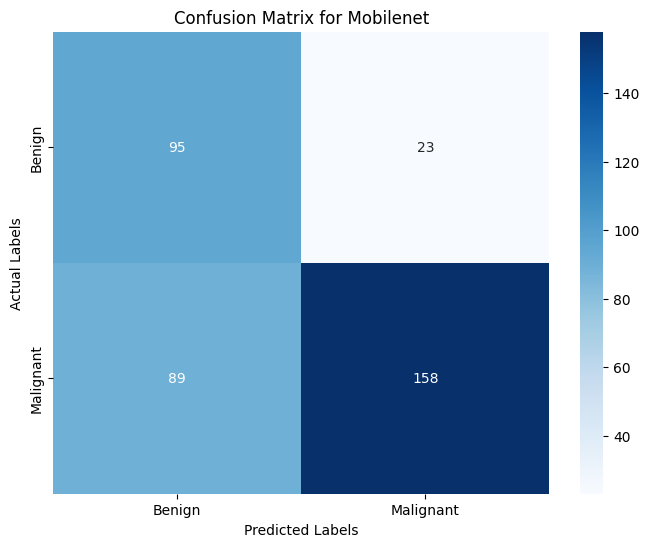

In [23]:
model_name= "Mobilenet"
evaluate_model(model_name,model_mobilenet, test_generator)

# Resnet50

In [24]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained ResNet50 model + higher-level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the complete model
model_resnet = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_resnet = model_resnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_resnet.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 21s 300ms/step - accuracy: 0.3238 - loss: 0.6959 - val_accuracy: 0.3352 - val_loss: 0.7019
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.3313 - loss: 0.6947 - val_accuracy: 0.5165 - val_loss: 0.6939
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.4320 - loss: 0.6949 - val_accuracy: 0.5440 - val_loss: 0.6926
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.4417 - loss: 0.7047 - val_accuracy: 0.5604 - val_loss: 0.6923
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.4645 - loss: 0.7009 - val_accuracy: 0.5714 - val_loss: 0.6919
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6213 - loss: 0.6797 - val_accuracy: 0.5989 - val_loss: 0.6901
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.4518 - loss: 0.6998 - val_accuracy: 0.6044 - val_loss: 0.6918
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.4750 - loss: 0.6983 - val_accuracy: 0.6099 - val

In [25]:
model_resnet.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 23,593,861 (90.00 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,100 (16.02 KB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step
Model: Resnet
Accuracy: 0.6630
Precision: 0.6902
Recall: 0.9109
F1 Score: 0.7853
Mean Absolute Error: 0.3370
Root Mean Square Error: 0.5805
AUC Score: 0.5262
Specificity: 0.1441



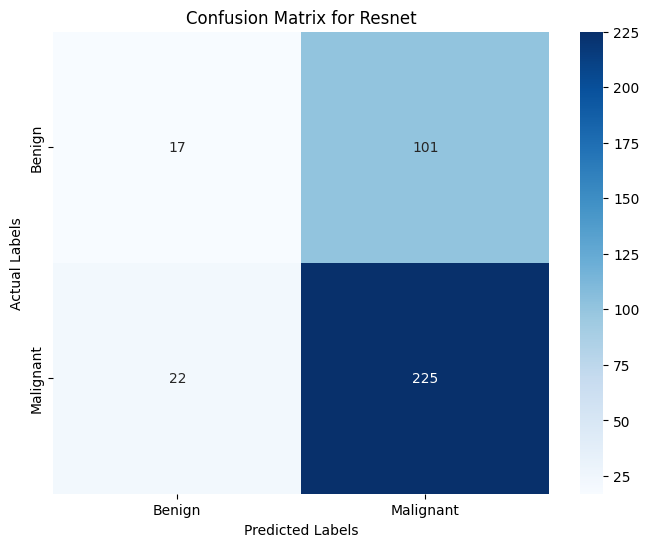

In [26]:
model_name= "Resnet"
evaluate_model(model_name,model_resnet, test_generator)

# Vgg19

In [27]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained VGG19 model + higher-level layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add Global Average Pooling and output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the complete model
model_vgg = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model with class weights
history_vgg = model_vgg.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model_vgg.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.3216 - loss: 0.7059 - val_accuracy: 0.3791 - val_loss: 0.7281
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.3572 - loss: 0.7006 - val_accuracy: 0.4396 - val_loss: 0.7052
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.4498 - loss: 0.6897 - val_accuracy: 0.4890 - val_loss: 0.6920
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.5014 - loss: 0.6803 - val_accuracy: 0.5495 - val_loss: 0.6858
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.5187 - loss: 0.6837 - val_accuracy: 0.5659 - val_loss: 0.6827
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.5393 - loss: 0.6775 - val_accuracy: 0.5549 - val_loss: 0.6808
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.5296 - loss: 0.6835 - val_accuracy: 0.5659 - val_loss: 0.6773
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.5833 - loss: 0.6840 - val_accuracy: 0.5714 - val

In [28]:
model_vgg.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 20,025,925 (76.39 MB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,028 (4.02 KB)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
Model: VGG19
Accuracy: 0.6822
Precision: 0.8503
Recall: 0.6437
F1 Score: 0.7327
Mean Absolute Error: 0.3178
Root Mean Square Error: 0.5637
AUC Score: 0.7668
Specificity: 0.7627



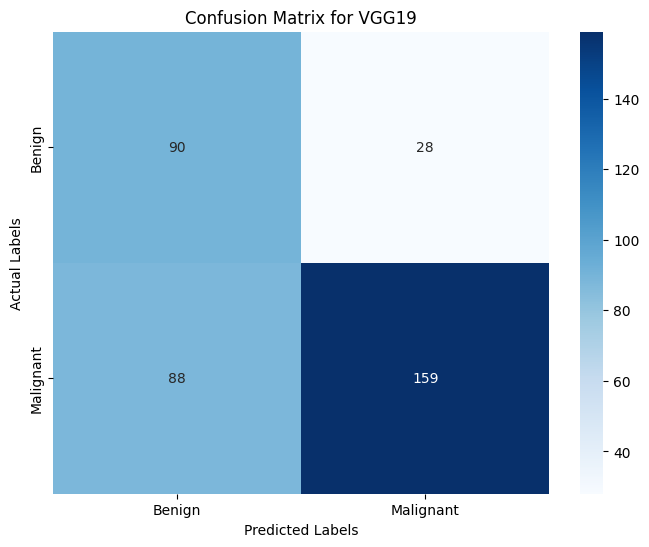

In [29]:
model_name= "VGG19"
evaluate_model(model_name,model_vgg, test_generator)

# Evaluation Curves

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step
Accuracy: 0.9288
Precision: 0.9784
Recall: 0.9150
F1 Score: 0.9456
Mean Absolute Error: 0.0712
Root Mean Square Error: 0.2669
AUC Score: 0.9838
Specificity: 0.9576


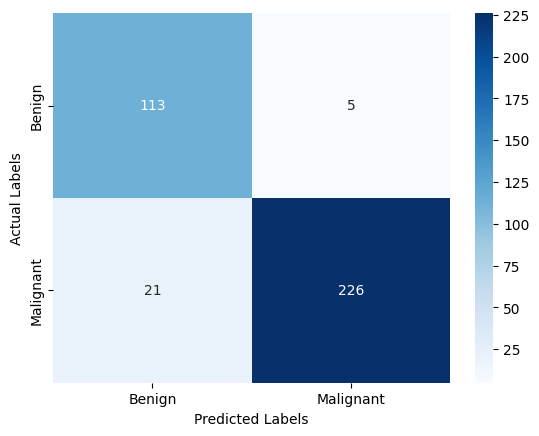

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Accuracy: 0.9233
Precision: 0.9782
Recall: 0.9069
F1 Score: 0.9412
Mean Absolute Error: 0.0767
Root Mean Square Error: 0.2770
AUC Score: 0.9823
Specificity: 0.9576


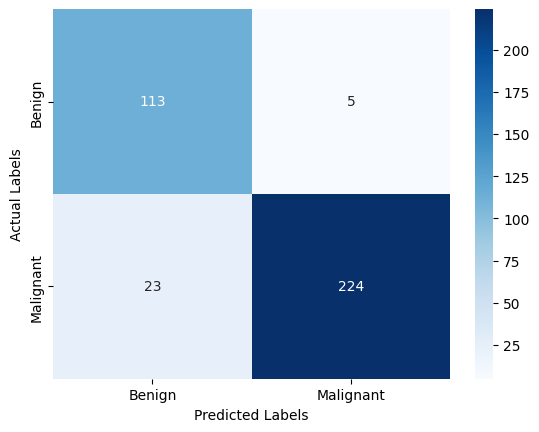

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Accuracy: 0.6740
Precision: 0.6758
Recall: 0.9960
F1 Score: 0.8052
Mean Absolute Error: 0.3260
Root Mean Square Error: 0.5710
AUC Score: 0.6280
Specificity: 0.0000


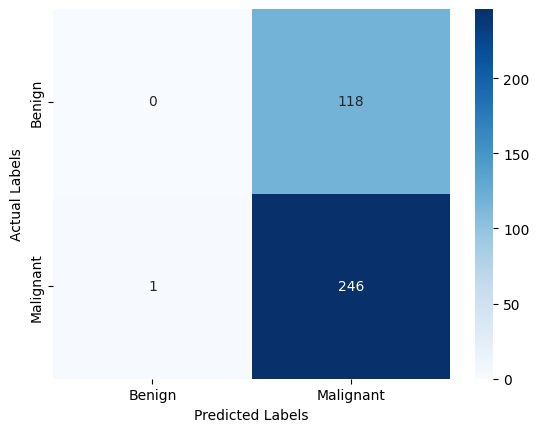

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Accuracy: 0.3233
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Mean Absolute Error: 0.6767
Root Mean Square Error: 0.8226
AUC Score: 0.8468
Specificity: 1.0000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


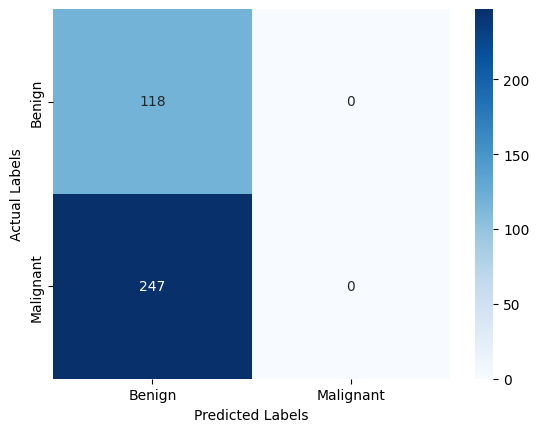

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Accuracy: 0.6822
Precision: 0.8394
Recall: 0.6559
F1 Score: 0.7364
Mean Absolute Error: 0.3178
Root Mean Square Error: 0.5637
AUC Score: 0.7799
Specificity: 0.7373


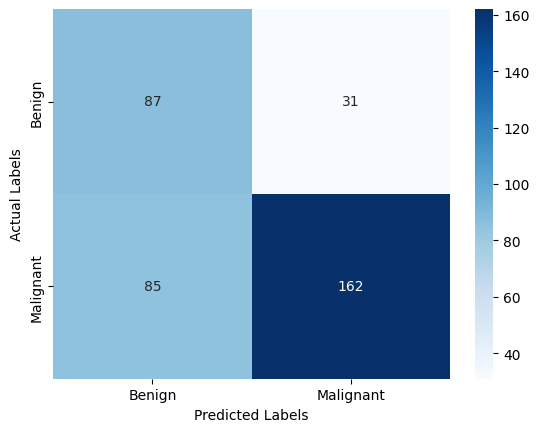

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Accuracy: 0.6932
Precision: 0.8729
Recall: 0.6397
F1 Score: 0.7383
Mean Absolute Error: 0.3068
Root Mean Square Error: 0.5539
AUC Score: 0.7721
Specificity: 0.8051


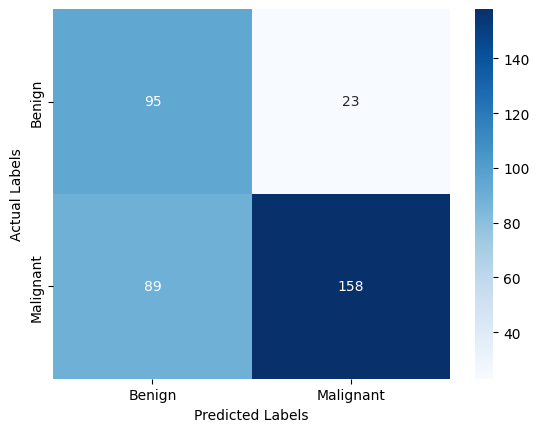

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Accuracy: 0.6630
Precision: 0.6902
Recall: 0.9109
F1 Score: 0.7853
Mean Absolute Error: 0.3370
Root Mean Square Error: 0.5805
AUC Score: 0.5262
Specificity: 0.1441


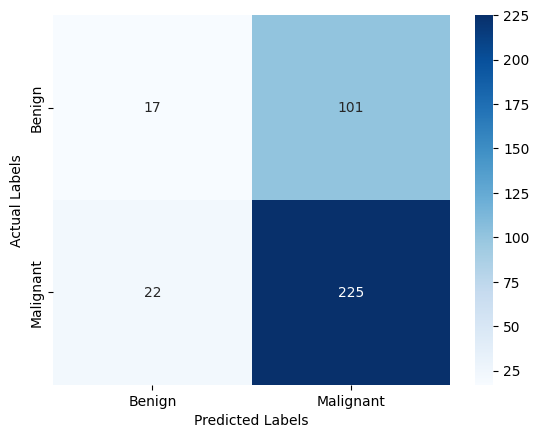

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Accuracy: 0.6822
Precision: 0.8503
Recall: 0.6437
F1 Score: 0.7327
Mean Absolute Error: 0.3178
Root Mean Square Error: 0.5637
AUC Score: 0.7668
Specificity: 0.7627


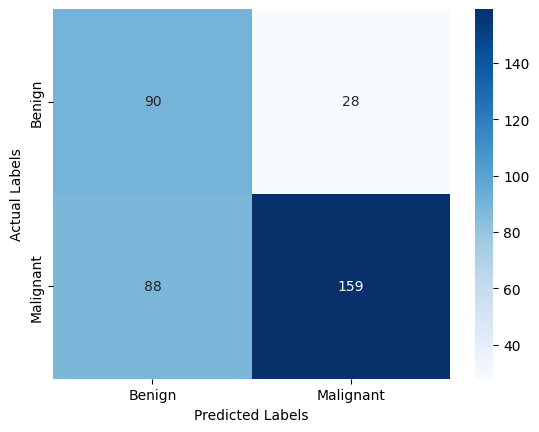

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    mean_absolute_error, 
    mean_squared_error,
    confusion_matrix
)

# Function to evaluate the model and print metrics
def evaluate_model(model_name, model, test_generator):
    # Get predictions
    test_generator.reset()  # Reset generator to start from the beginning
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_prob)
    
    # Calculate specificity
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    # plt.title(f"Confusion Matrix for {name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'Confusion_{model_name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()

# Evaluate the model on the test set
model_name= "DNBCD"
evaluate_model(model_name,model, test_generator)
model_name= "T_Mobilenet"
evaluate_model(model_name,mobilenet_model, test_generator)
model_name= "T_Resnet"
evaluate_model(model_name,resnet50_model, test_generator)
model_name= "T_VGG19"
evaluate_model(model_name,vgg19_model, test_generator)
model_name= "Densenet"
evaluate_model(model_name,model_densenet, test_generator)
model_name= "Mobilenet"
evaluate_model(model_name,model_mobilenet, test_generator)
model_name= "Resnet"
evaluate_model(model_name,model_resnet, test_generator)
model_name= "VGG19"
evaluate_model(model_name,model_vgg, test_generator)

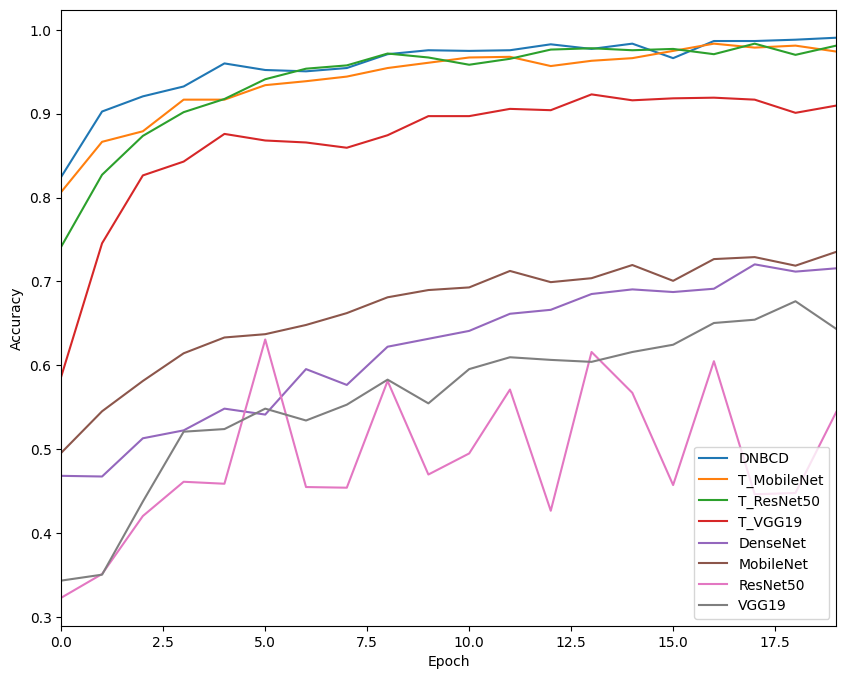

In [37]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['accuracy']
acc_tmobilenet = mobilenet_history_fine.history['accuracy']
acc_tresnet50 = resnet50_history_fine.history['accuracy']
acc_tvgg19 = vgg19_history_fine.history['accuracy']
acc_densenet = history_densenet.history['accuracy']
acc_mobilenet = history_mobilenet.history['accuracy']
acc_resnet50 = history_resnet.history['accuracy']
acc_vgg19 = history_vgg.history['accuracy']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# Set legend in bottom-right corner
plt.legend(loc='lower right')

# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Accuracy.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


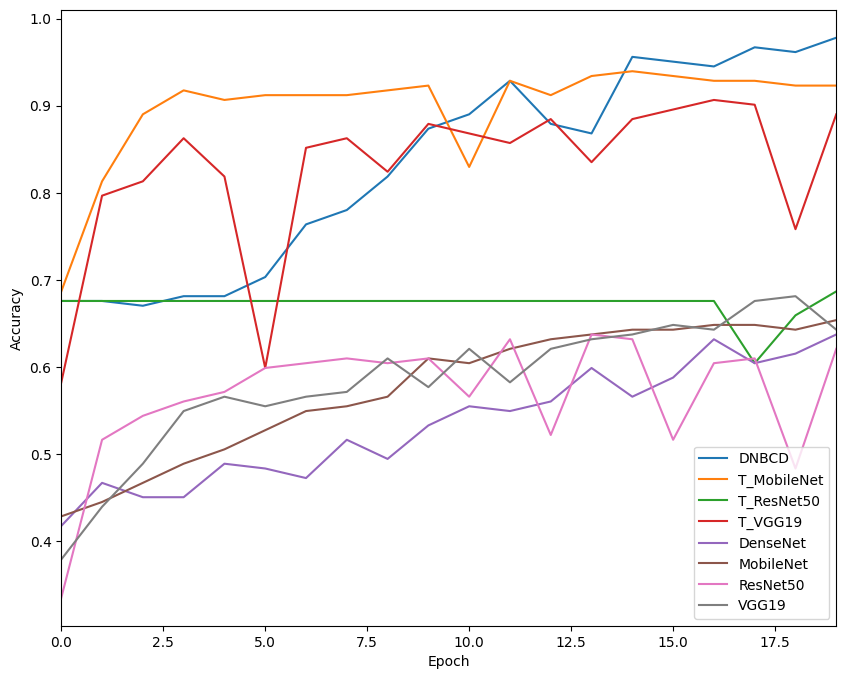

In [38]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['val_accuracy']
acc_tmobilenet = mobilenet_history_fine.history['val_accuracy']
acc_tresnet50 = resnet50_history_fine.history['val_accuracy']
acc_tvgg19 = vgg19_history_fine.history['val_accuracy']
acc_densenet = history_densenet.history['val_accuracy']
acc_mobilenet = history_mobilenet.history['val_accuracy']
acc_resnet50 = history_resnet.history['val_accuracy']
acc_vgg19 = history_vgg.history['val_accuracy']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Set legend in bottom-right corner
plt.legend(loc='lower right')

# Remove gap from the x-axis
plt.gca().margins(x=0)

beingsaved.savefig('Val_Accuracy.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


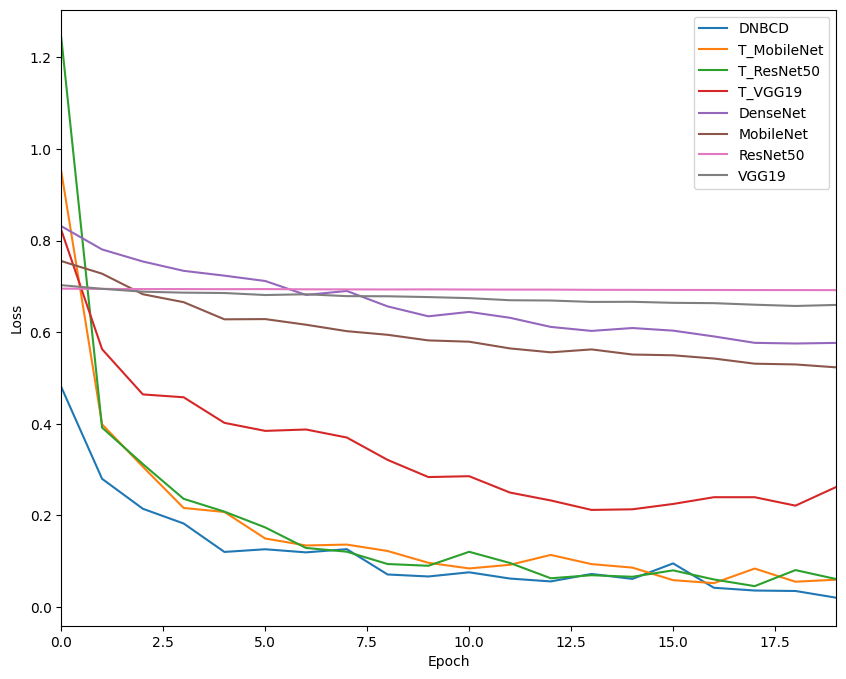

In [39]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['loss']
acc_tmobilenet = mobilenet_history_fine.history['loss']
acc_tresnet50 = resnet50_history_fine.history['loss']
acc_tvgg19 = vgg19_history_fine.history['loss']
acc_densenet = history_densenet.history['loss']
acc_mobilenet = history_mobilenet.history['loss']
acc_resnet50 = history_resnet.history['loss']
acc_vgg19 = history_vgg.history['loss']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()


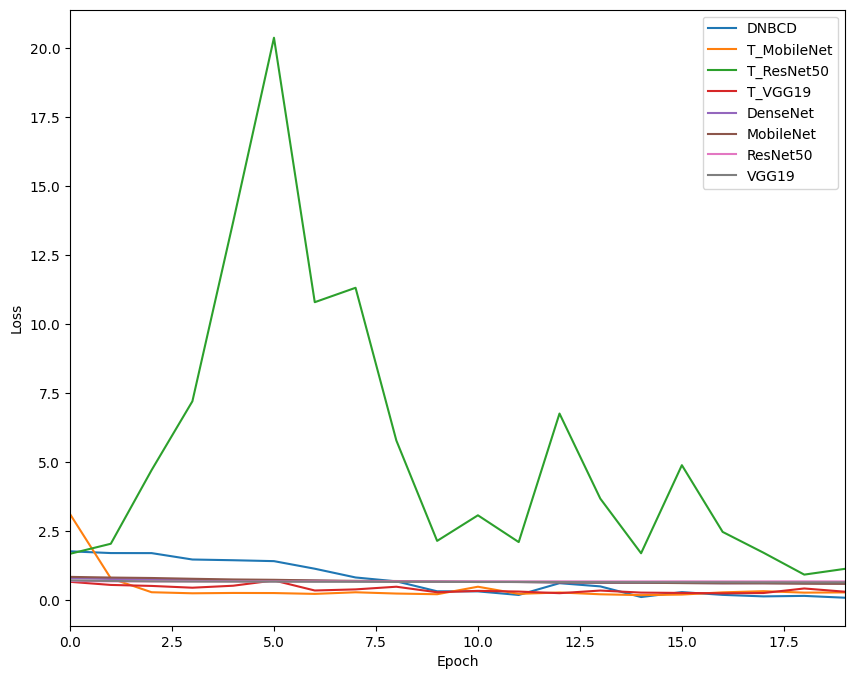

In [41]:
import matplotlib.pyplot as plt

# Accuracy values
acc_dnbcd = history_fine.history['val_loss']
acc_tmobilenet = mobilenet_history_fine.history['val_loss']
acc_tresnet50 = resnet50_history_fine.history['val_loss']
acc_tvgg19 = vgg19_history_fine.history['val_loss']
acc_densenet = history_densenet.history['val_loss']
acc_mobilenet = history_mobilenet.history['val_loss']
acc_resnet50 = history_resnet.history['val_loss']
acc_vgg19 = history_vgg.history['val_loss']

beingsaved = plt.figure(figsize=(10, 8))

plt.plot(acc_dnbcd, label='DNBCD')
plt.plot(acc_tmobilenet, label='T_MobileNet')
plt.plot(acc_tresnet50, label='T_ResNet50')
plt.plot(acc_tvgg19, label='T_VGG19')
plt.plot(acc_densenet, label='DenseNet')
plt.plot(acc_mobilenet, label='MobileNet')
plt.plot(acc_resnet50, label='ResNet50')
plt.plot(acc_vgg19, label='VGG19')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Remove gap from the y-axis
plt.gca().margins(x=0)

beingsaved.savefig('Val_Loss.png', format='png', dpi=600, bbox_inches="tight")
plt.show()
